# Electricity Price Forecasting

## Overview

Data exploration, visualization and implementation of a forecasting model for elecricity price given the hisorical price and the load data and wind generation data.

Data used is from the NordPool market, which is freely available from their website NordPoolgroup.com

## Data Exploration

The data will be downloaded, saved locally and then scaled appropriately, before being uploaded to S3

In [1]:
import sys
sys.executable

'/home/ec2-user/anaconda3/envs/python3/bin/python'

In [168]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer
from epftoolbox.data import read_data
from epftoolbox.data import DataScaler
import matplotlib.pyplot as plt
import io
import os
import time
import json


# Session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/EPF_linear_learner'

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

In [10]:
path = 'NordPool_data/'
dataset = 'NP'
# Want our test dataset to be the last 2 years of the total dataset, which is 6 years
years_test = 2 
df_train, df_test = read_data(path=path, dataset=dataset, years_test=years_test)
df_train.head()

,Price,Exogenous 1,Exogenous 2
Date,,,
2013-01-01 00:00:00,31.05,42497.0,2798.0
2013-01-01 01:00:00,30.47,41463.0,2417.0
2013-01-01 02:00:00,28.92,40812.0,2036.0
2013-01-01 03:00:00,27.88,40246.0,1706.0
2013-01-01 04:00:00,26.96,40088.0,1427.0


Text(0.5, 0.98, 'Price Data, Load Data (Exogenous 1) and Wind Generation (Exogenous 2)')

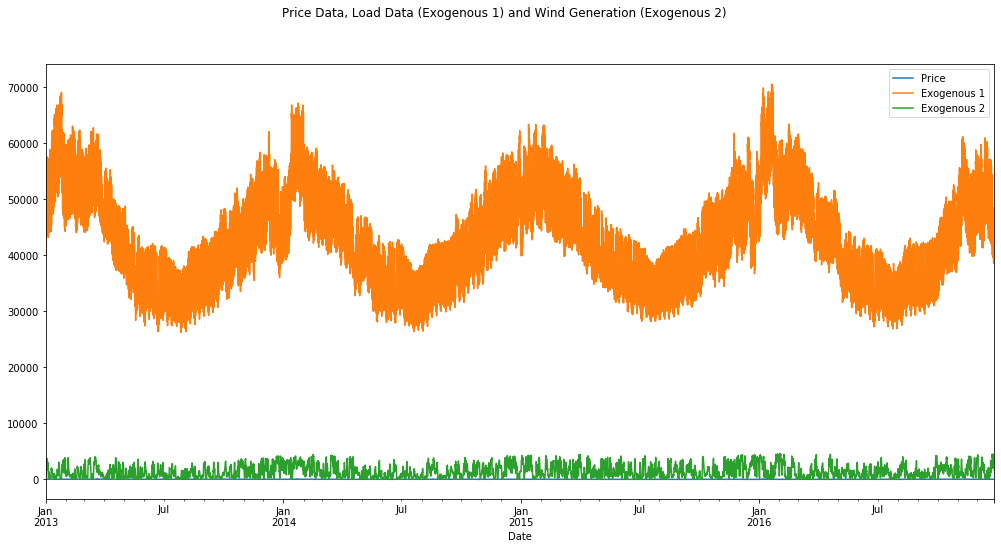

In [13]:
original_data = pd.read_csv('NordPool_data/NP.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
#ax = fig.add_subplot(111)
df_train.plot(figsize=(17, 8))
plt.suptitle('Price Data, Load Data (Exogenous 1) and Wind Generation (Exogenous 2)')

As seen from the above plot, the values for the day-ahead load forecast and the day-ahead wind generation forecast are so much greater than the day-ahead price, that the price data is barely visible on the plot.

This indicates the data needs to be scaled prior to training or testing.

Text(0.5, 0.98, 'Day-ahead Price Data, Jan 2013 - Dec 2016')

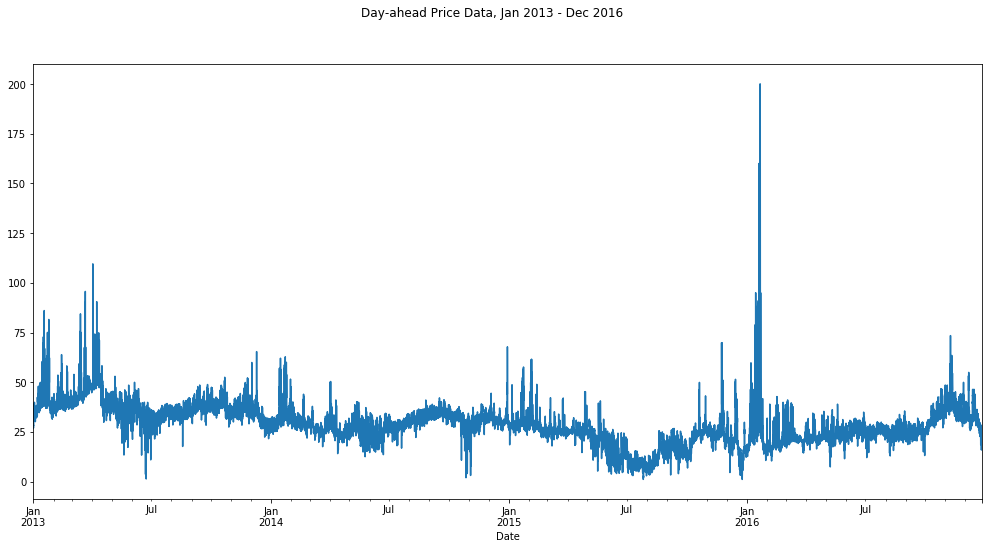

In [14]:
df_train.Price.plot(figsize=(17, 8))
plt.suptitle('Day-ahead Price Data, Jan 2013 - Dec 2016')

Text(0.5, 0.98, 'Day-ahead Load Forecast, Jan 2013 - Dec 2016')

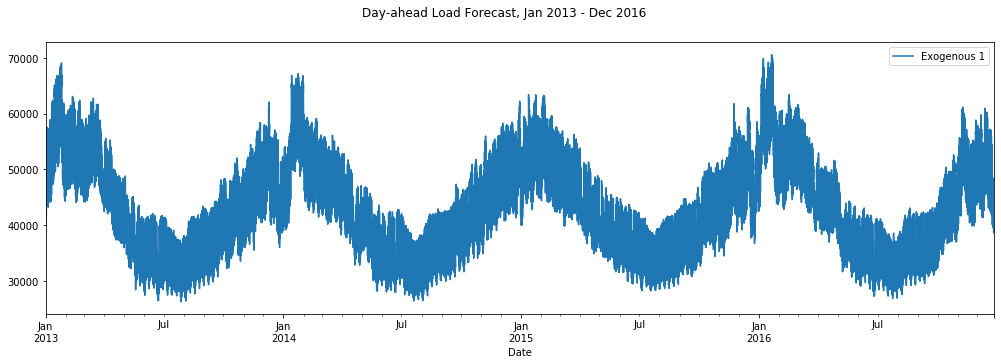

In [21]:
#df_train.Price.plot(figsize=(17, 5))
df_train.plot(y='Exogenous 1', figsize=(17, 5))
plt.suptitle('Day-ahead Load Forecast, Jan 2013 - Dec 2016')

Text(0.5, 0.98, 'Day-ahead Wind Forecast, Jan 2013 - Dec 2016')

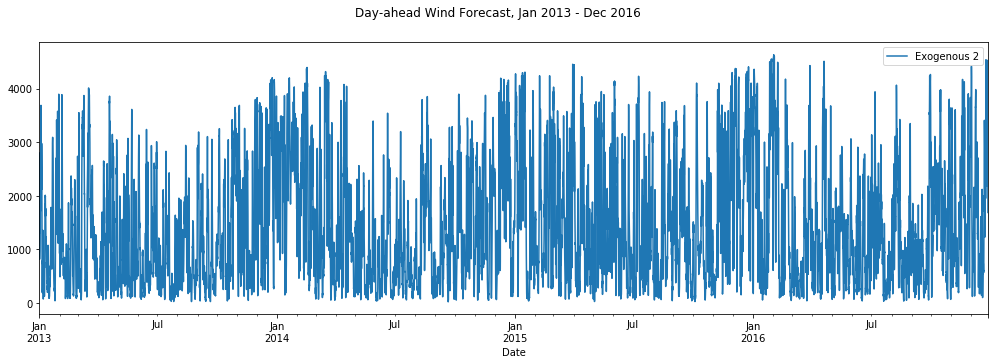

In [22]:
df_train.plot(y='Exogenous 2', figsize=(17, 5))
plt.suptitle('Day-ahead Wind Forecast, Jan 2013 - Dec 2016')

Create a scaler for the input data

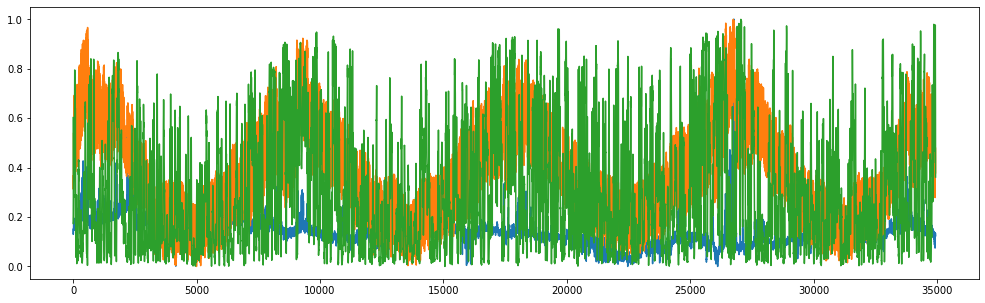

In [163]:
Xtrain = df_train.values
Xtest = df_test.values
scaler_X = DataScaler('Norm')
Xtrain_scaled = scaler_X.fit_transform(Xtrain)
Xtest_scaled = scaler_X.transform(Xtest)
Xtrain_inverse = scaler_X.inverse_transform(Xtrain_scaled)
Xtest_inverse = scaler_X.inverse_transform(Xtest_scaled)

plt.figure(figsize=(17,5))
plt.plot(Xtrain_scaled)

Create a scaler for the output training data

In [96]:
df_test.head()

,Price,Exogenous 1,Exogenous 2
Date,,,
2016-12-27 00:00:00,24.08,42653.0,2124.0
2016-12-27 01:00:00,22.52,41868.0,1905.0
2016-12-27 02:00:00,20.13,41534.0,2053.0
2016-12-27 03:00:00,19.86,41642.0,2274.0
2016-12-27 04:00:00,20.09,42418.0,2549.0


[[31.05]
 [30.47]
 [28.92]]


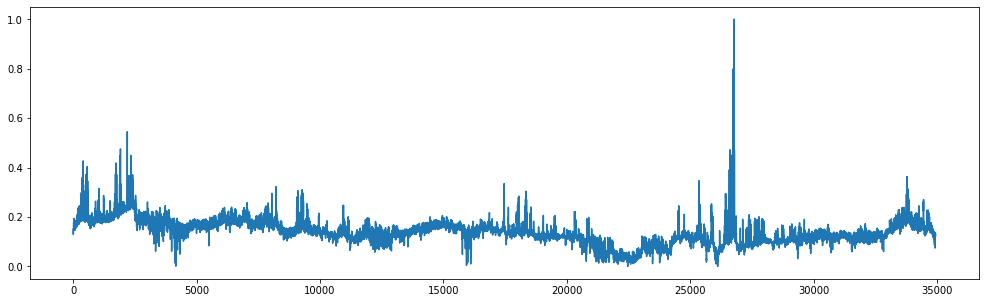

In [153]:
Ytrain = df_train.Price.values
YtrainR = Ytrain.reshape(-1,1)
print(YtrainR[0:3])

# Use the same type of normalisation as the test
scaler_Y = DataScaler('Norm')
Ytrain_scaled = scaler_Y.fit_transform(YtrainR)
plt.figure(figsize=(17,5))
plt.plot(Ytrain_scaled)

Now that each time series has been scaled to a value between 0 and 1, we can use them to train or model.

<class 'numpy.ndarray'>


Text(0.5, 0.98, 'Training Label Data, scaled')

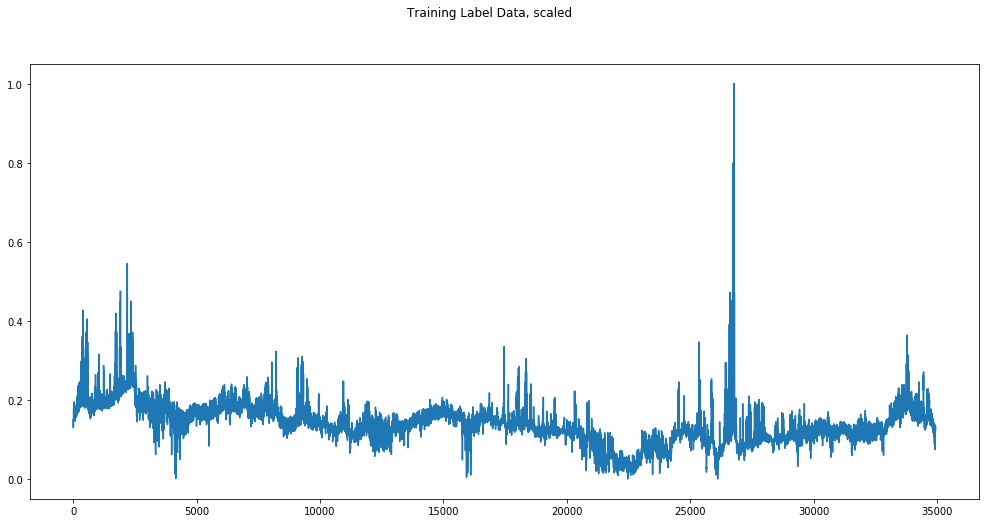

In [162]:
# The label is the price of the electricty and the wind and load data are the features
train_y = Ytrain_scaled
    
train_X = np.delete(Xtrain_scaled, obj=0, axis=1) # Remove the price for the training set

plt.figure(figsize=(17,8))
plt.plot(train_y)
plt.suptitle('Training Label Data, scaled')

Text(0.5, 0.98, 'Training Input Data, scaled')

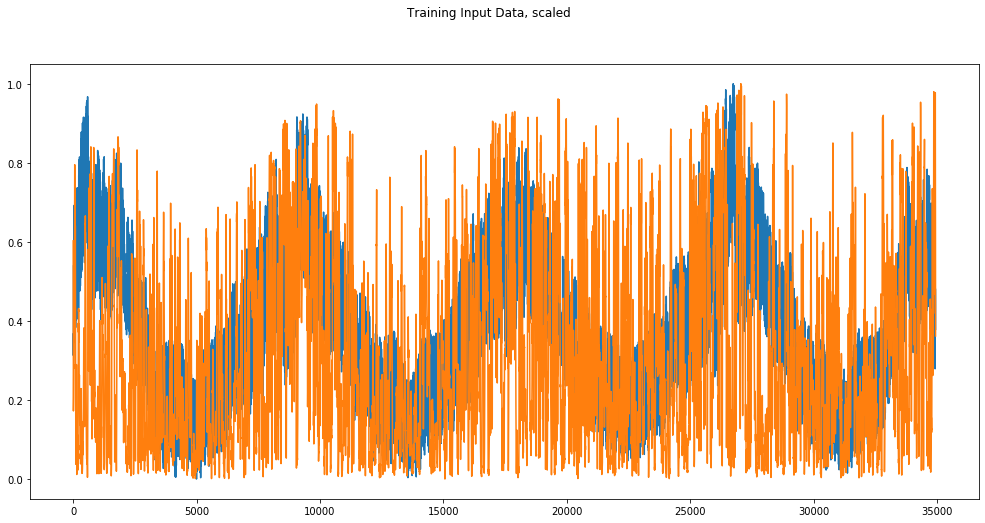

In [155]:
plt.figure(figsize=(17,8))
plt.plot(train_X)
plt.suptitle('Training Input Data, scaled')

Text(0.5, 0.98, 'Test Input Data, scaled')

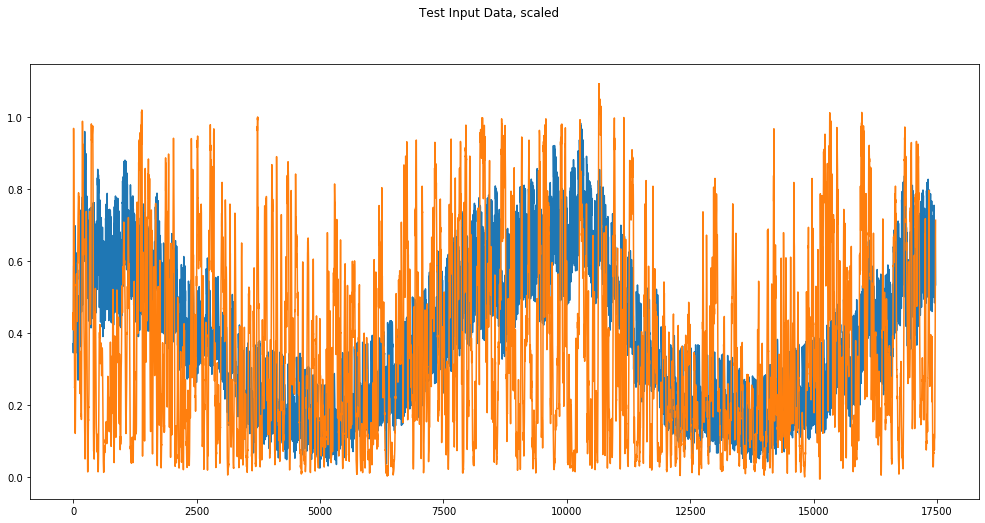

In [164]:
# Repeat for test set
test_X = np.delete(Xtest_scaled,obj=0, axis=1) # Remove the price for the test input set

plt.figure(figsize=(17,8))
plt.plot(test_X)
plt.suptitle('Test Input Data, scaled')

First we need to convert our training series to ther ecordIO-wrapped protobuf format that SageMaker algorithms use

In [166]:
train_y = train_y.reshape(-1)

print(train_y.shape)
# Turn lables back into Series object
train_y = pd.Series(train_y)
train_y.head()

(34944,)


0    0.150430
1    0.147513
2    0.139717
3    0.134487
4    0.129860
dtype: float64

In [167]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_y).astype('float32'))
buf.seek(0)

0

Upload the training set

In [169]:
key = 'linear_train.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-eu-west-1-871247501960/sagemaker/EPF_linear_learner/train/linear_train.data


In [170]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [171]:
estimator = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sagemaker_session)
estimator.set_hyperparameters(feature_dim=2,
                           mini_batch_size=100,
                           predictor_type='regressor',
                           epochs=10,
                           loss='absolute_loss')

estimator.fit({'train': s3_train_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-11-22 17:48:45 Starting - Starting the training job...
2020-11-22 17:48:47 Starting - Launching requested ML instances......
2020-11-22 17:49:52 Starting - Preparing the instances for training......
2020-11-22 17:50:50 Downloading - Downloading input data...
2020-11-22 17:51:43 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/22/2020 17:51:47 INFO 140400833820480] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_

[2020-11-22 17:52:07.479] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 6215, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.782285819313246, "sum": 0.782285819313246, "min": 0.782285819313246}}, "EndTime": 1606067527.47945, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1606067527.47925}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6710211170710261, "sum": 0.6710211170710261, "min": 0.6710211170710261}}, "EndTime": 1606067527.479548, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1606067527.479529}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.7821648005018261, "sum": 0.7821648005018261, "min": 0.7821648005018261}}, "EndTime": 1606067527.4

[2020-11-22 17:52:13.913] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 6423, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.8687609687575638, "sum": 0.8687609687575638, "min": 0.8687609687575638}}, "EndTime": 1606067533.914005, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1606067533.913925}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6727274071657897, "sum": 0.6727274071657897, "min": 0.6727274071657897}}, "EndTime": 1606067533.914093, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1606067533.914077}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.8687389312022736, "sum": 0.8687389312022736, "min": 0.8687389312022736}}, "EndTime": 1606067

[2020-11-22 17:52:26.154] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 6052, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9500861756507851, "sum": 0.9500861756507851, "min": 0.9500861756507851}}, "EndTime": 1606067546.154805, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1606067546.15472}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6779558833485688, "sum": 0.6779558833485688, "min": 0.6779558833485688}}, "EndTime": 1606067546.154885, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1606067546.154867}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9501449780067946, "sum": 0.9501449780067946, "min": 0.9501449780067946}}, "EndTime": 1606067

[2020-11-22 17:52:32.502] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 6339, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9587334745183032, "sum": 0.9587334745183032, "min": 0.9587334745183032}}, "EndTime": 1606067552.502937, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1606067552.502853}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6808717080037027, "sum": 0.6808717080037027, "min": 0.6808717080037027}}, "EndTime": 1606067552.503023, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1606067552.503003}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9587380469357728, "sum": 0.9587380469357728, "min": 0.9587380469357728}}, "EndTime": 160606

[2020-11-22 17:52:44.421] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 6109, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9534735081735518, "sum": 0.9534735081735518, "min": 0.9534735081735518}}, "EndTime": 1606067564.421524, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1606067564.421429}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6871209400089558, "sum": 0.6871209400089558, "min": 0.6871209400089558}}, "EndTime": 1606067564.421646, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1606067564.421624}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9534738163825093, "sum": 0.9534738163825093, "min": 0.9534738163825093}}, "EndTime": 160606


2020-11-22 17:52:56 Uploading - Uploading generated training model
2020-11-22 17:52:56 Completed - Training job completed
Training seconds: 126
Billable seconds: 126


Deployment

In [ ]:
predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

--------------!

In [173]:
predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer

In [184]:
result = predictor.predict(test_X)

one_step = np.array([r['score'] for r in result['predictions']])
print(one_step.shape)
one_step_squeeze = np.squeeze(one_step)
print(one_step_squeeze.shape)
#one_step = one_step.reshape(-1,1)
scaled_one_step = scaler_Y.inverse_transform(one_step.reshape(1,-1))


The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


(17472,)
(17472,)


In [188]:
print(one_step[0:3])
print(scaled_one_step[:3])
print(scaled_one_step.shape)
one_step_R = scaled_one_step.reshape(-1,1)
print(one_step_R.shape)
print(test_y.shape)

[0.1648483  0.16387093 0.16201398]
[[33.91678706 33.72245715 33.3532392  ... 38.08775466 37.52590744
  36.70216075]]
(1, 17472)
(17472, 1)
(17472,)


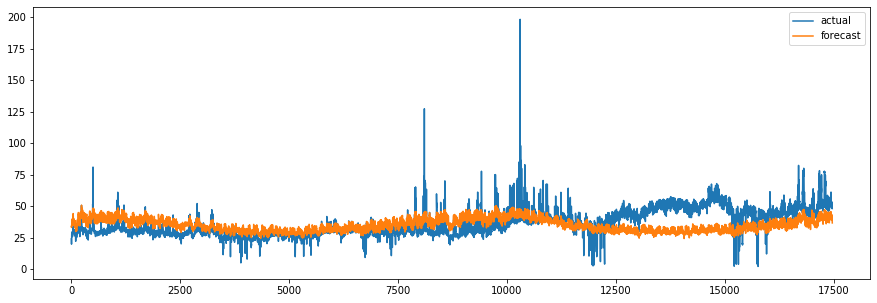

In [197]:
#print('One-step-ahead MdAPE = ', np.median(np.abs(test_y - one_step_R) / test_y))
plt.figure(figsize=(15,5))
plt.plot(np.array(test_y), label='actual')
plt.plot(one_step_R, label='forecast')
plt.legend()
plt.show()

## Delete Endpoint

In [79]:
sagemaker_session.delete_endpoint(endpoint_name)

NameError: name 'endpoint_name' is not defined